In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [3]:
df = pd.read_csv('dynamic_pricing.csv')
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [4]:
df.shape

(1000, 10)

In [5]:
df.isnull().sum()

Number_of_Riders           0
Number_of_Drivers          0
Location_Category          0
Customer_Loyalty_Status    0
Number_of_Past_Rides       0
Average_Ratings            0
Time_of_Booking            0
Vehicle_Type               0
Expected_Ride_Duration     0
Historical_Cost_of_Ride    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


In [7]:
df.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


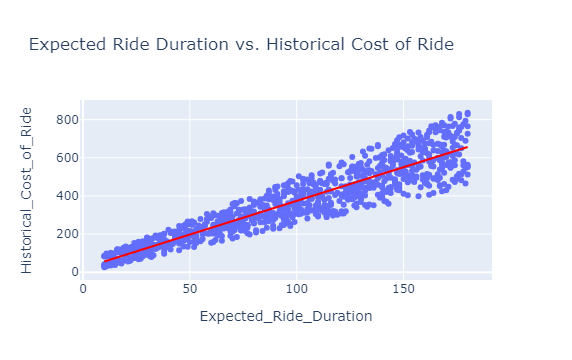

In [9]:
# relationship between expected ride duration and the historical cost of the ride
fig = px.scatter(df, x='Expected_Ride_Duration', 
                 y='Historical_Cost_of_Ride',
                 title='Expected Ride Duration vs. Historical Cost of Ride', 
                 trendline='ols',
                trendline_color_override='red')
fig.show()

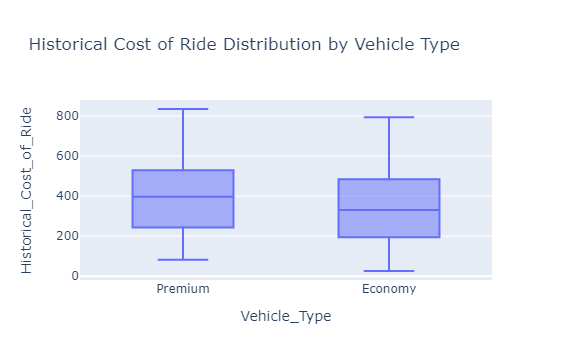

In [10]:
# distribution of the historical cost of rides based on the vehicle type
fig = px.box(df, x='Vehicle_Type', 
             y='Historical_Cost_of_Ride',
             title='Historical Cost of Ride Distribution by Vehicle Type')
fig.show()

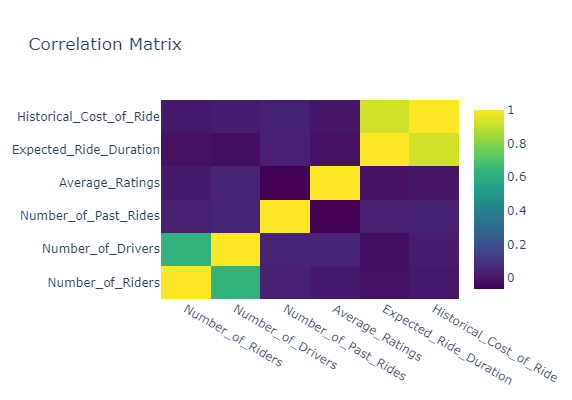

In [13]:
num_df = df.select_dtypes(include='number')
corr_matrix = num_df.corr()

fig = go.Figure(data=go.Heatmap(z=corr_matrix.values, 
                                x=corr_matrix.columns, 
                                y=corr_matrix.columns,
                                colorscale='Viridis'))
fig.update_layout(title='Correlation Matrix',width = 500, height = 400)
fig.show()

Implementing a Dynamic Pricing Strategy

The data provided by the company states that the company uses a pricing model that only takes the expected ride duration as a factor to determine the price for a ride. Now, we will implement a dynamic pricing strategy aiming to adjust the ride costs dynamically based on the demand and supply levels observed in the data. It will capture high-demand periods and low-supply scenarios to increase prices, while low-demand periods and high-supply situations will lead to price reductions

In [15]:
import numpy as np

# Calculate demand_multiplier based on percentile for high and low demand
high_demand_percentile = 75
low_demand_percentile = 25

df['demand_multiplier'] = np.where(df['Number_of_Riders'] > np.percentile(df['Number_of_Riders'], high_demand_percentile),
                                     df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], high_demand_percentile),
                                     df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], low_demand_percentile))

# Calculate supply_multiplier based on percentile for high and low supply
high_supply_percentile = 75
low_supply_percentile = 25

df['supply_multiplier'] = np.where(df['Number_of_Drivers'] > np.percentile(df['Number_of_Drivers'], low_supply_percentile),
                                     np.percentile(df['Number_of_Drivers'], high_supply_percentile) / df['Number_of_Drivers'],
                                     np.percentile(df['Number_of_Drivers'], low_supply_percentile) / df['Number_of_Drivers'])

# Define price adjustment factors for high and low demand/supply
demand_threshold_high = 1.2  # Higher demand threshold
demand_threshold_low = 0.8  # Lower demand threshold
supply_threshold_high = 0.8  # Higher supply threshold
supply_threshold_low = 1.2  # Lower supply threshold

# Calculate adjusted_ride_cost for dynamic pricing
df['adjusted_ride_cost'] = df['Historical_Cost_of_Ride'] * (
    np.maximum(df['demand_multiplier'], demand_threshold_low) *
    np.maximum(df['supply_multiplier'], supply_threshold_high)
)


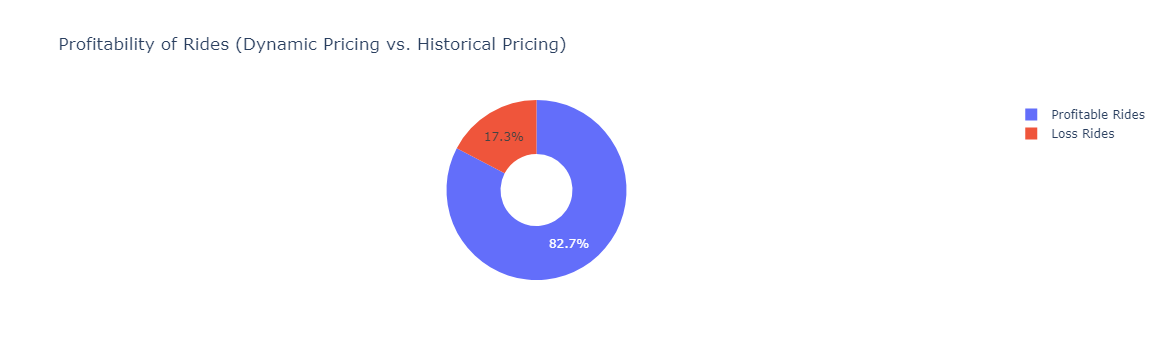

In [20]:
# Calculate the profit percentage for each ride
df['profit_percentage'] = ((df['adjusted_ride_cost'] - df['Historical_Cost_of_Ride']) / df['Historical_Cost_of_Ride']) * 100
# Identify profitable rides where profit percentage is positive
profitable_rides = df[df['profit_percentage'] > 0]

# Identify loss rides where profit percentage is negative
loss_rides = df[df['profit_percentage'] < 0]


import plotly.graph_objects as go

# Calculate the count of profitable and loss rides
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

# Create a donut chart to show the distribution of profitable and loss rides
labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

fig = go.Figure(go.Pie(labels=labels, values=values, hole=0.4))
fig.update_layout(title='Profitability of Rides (Dynamic Pricing vs. Historical Pricing)')
fig.show()

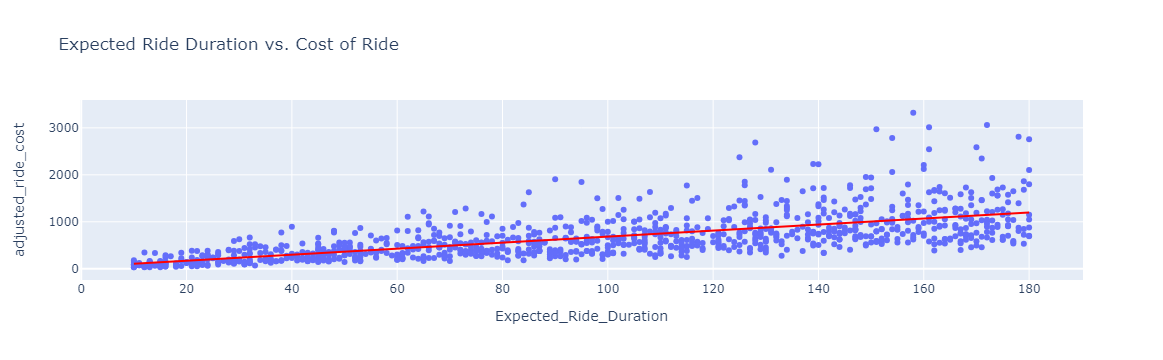

In [23]:
# expected ride duration and the cost of the ride based on the dynamic pricing strategy
fig = px.scatter(df, 
                 x='Expected_Ride_Duration', 
                 y='adjusted_ride_cost',
                 title='Expected Ride Duration vs. Cost of Ride', 
                 trendline='ols',
                trendline_color_override='red')
fig.show()

In [24]:
from sklearn.preprocessing import StandardScaler

def data_preprocessing_pipeline(df):
    #Identify numeric and categorical features
    numeric_features = df.select_dtypes(include=['float', 'int']).columns
    categorical_features = df.select_dtypes(include=['object']).columns

    #Handle missing values in numeric features
    df[numeric_features] = df[numeric_features].fillna(df[numeric_features].mean())

    #Detect and handle outliers in numeric features using IQR
    for feature in numeric_features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        data[feature] = np.where((df[feature] < lower_bound) | (df[feature] > upper_bound),
                                 df[feature].mean(), df[feature])

    #Handle missing values in categorical features
    df[categorical_features] = df[categorical_features].fillna(df[categorical_features].mode().iloc[0])

    return df

In [25]:
df["Vehicle_Type"] = df["Vehicle_Type"].map({"Premium": 1, 
                                           "Economy": 0})

In [26]:
#splitting data
from sklearn.model_selection import train_test_split
x = np.array(df[["Number_of_Riders", "Number_of_Drivers", "Vehicle_Type", "Expected_Ride_Duration"]])
y = np.array(df[["adjusted_ride_cost"]])

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Reshape y to 1D array
y_train = y_train.ravel()
y_test = y_test.ravel()

# Training a random forest regression model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

In [27]:
def get_vehicle_type_numeric(vehicle_type):
    vehicle_type_mapping = {
        "Premium": 1,
        "Economy": 0
    }
    vehicle_type_numeric = vehicle_type_mapping.get(vehicle_type)
    return vehicle_type_numeric
  
# Predicting using user input values
def predict_price(number_of_riders, number_of_drivers, vehicle_type, Expected_Ride_Duration):
    vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
    if vehicle_type_numeric is None:
        raise ValueError("Invalid vehicle type")
    
    input_data = np.array([[number_of_riders, number_of_drivers, vehicle_type_numeric, Expected_Ride_Duration]])
    predicted_price = model.predict(input_data)
    return predicted_price

# Example prediction using user input values
user_number_of_riders = 50
user_number_of_drivers = 25
user_vehicle_type = "Economy"
Expected_Ride_Duration = 30
predicted_price = predict_price(user_number_of_riders, user_number_of_drivers, user_vehicle_type, Expected_Ride_Duration)
print("Predicted price:", predicted_price)

Predicted price: [245.14862946]


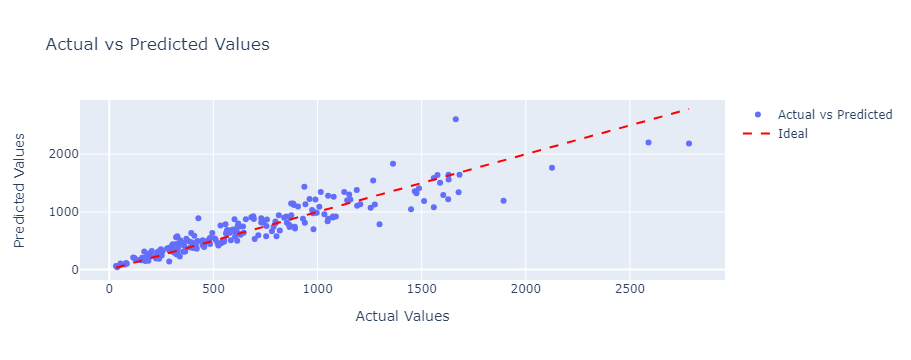

In [28]:
import plotly.graph_objects as go

# Predict on the test set
y_pred = model.predict(x_test)

# Create a scatter plot with actual vs predicted values
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_test.flatten(),
    y=y_pred,
    mode='markers',
    name='Actual vs Predicted'
))

# Add a line representing the ideal case
fig.add_trace(go.Scatter(
    x=[min(y_test.flatten()), max(y_test.flatten())],
    y=[min(y_test.flatten()), max(y_test.flatten())],
    mode='lines',
    name='Ideal',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title='Actual vs Predicted Values',
    xaxis_title='Actual Values',
    yaxis_title='Predicted Values',
    showlegend=True,
)

fig.show()